In [128]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# 加载数据
dataset = nc.Dataset('../data/io_ML_10t.nc')

# 定义输入和输出变量列表
input_vars = {
    "U": dataset.variables["U"][:],
    "V": dataset.variables["V"][:],
    "T": dataset.variables["T"][:],
    "Q": dataset.variables["Q"][:],
    "CLDLIQ": dataset.variables["CLDLIQ"][:],
    "CLDICE": dataset.variables["CLDICE"][:],
    "NUMLIQ": dataset.variables["NUMLIQ"][:],
    "NUMICE": dataset.variables["NUMICE"][:],
    "PS": np.expand_dims(dataset.variables["PS"], axis=1),
    "PMID": dataset.variables["PMID"][:],
    "DPRES": dataset.variables["DPRES"][:],
    "Z3": dataset.variables["Z3"][:],
    "HEIGHT": dataset.variables["HEIGHT"][:],
    "TAUX": np.expand_dims(dataset.variables["TAUX"], axis=1),
    "TAUY": np.expand_dims(dataset.variables["TAUY"], axis=1),
    "SHFLX": np.expand_dims(dataset.variables["SHFLX"], axis=1),
    "LHFLX": np.expand_dims(dataset.variables["LHFLX"], axis=1)
}

output_vars = {
    "SPDQ": dataset.variables["SPDQ"][:],
    "SPDQC": dataset.variables["SPDQC"][:],
    "SPDQI": dataset.variables["SPDQI"][:],
    "SPNC": dataset.variables["SPNC"][:],
    "SPNI": dataset.variables["SPNI"][:],
    "SPDT": dataset.variables["SPDT"][:],
    "CLOUD": dataset.variables["CLOUD"][:],
    "CLDTOT": np.expand_dims(dataset.variables["CLDTOT"], axis=1),
    "CLDHGH": np.expand_dims(dataset.variables["CLDHGH"], axis=1),
    "CLDMED": np.expand_dims(dataset.variables["CLDMED"], axis=1),
    "CLDLOW": np.expand_dims(dataset.variables["CLDLOW"], axis=1),
    "PRECC": np.expand_dims(dataset.variables["PRECC"], axis=1),
    "PRECSC": np.expand_dims(dataset.variables["PRECSC"], axis=1),
    "CLOUDTOP": dataset.variables["CLOUDTOP"][:],
    "QRL": dataset.variables["QRL"][:],
    "QRS": dataset.variables["QRS"][:],
    "FSNT": np.expand_dims(dataset.variables["FSNT"], axis=1),
    "FSDS": np.expand_dims(dataset.variables["FSDS"], axis=1),
    "FSNS": np.expand_dims(dataset.variables["FSNS"], axis=1),
    "FLNS": np.expand_dims(dataset.variables["FLNS"], axis=1),
    "FLNT": np.expand_dims(dataset.variables["FLNT"], axis=1)
}

# 合并输入和输出数据
input = np.concatenate(list(input_vars.values()), axis=1, dtype=np.float32)
output = np.concatenate(list(output_vars.values()), axis=1, dtype=np.float32)

# 重塑数据
input_reshaped_train = input[:9,:,:,:].reshape((input.shape[1], -1))
input_reshaped_test = input[9:,:,:,:].reshape((input.shape[1], -1))
output_reshaped_train = output[:9,:,:,:].reshape((output.shape[1], -1))
output_reshaped_test = output[9:,:,:,:].reshape((output.shape[1], -1))

# 定义归一化函数
def normalize_data(data, method='range', **kwargs):
    """
    对数据进行归一化
    参数:
        data: 输入数据 (n_features, n_samples)
        method: 归一化方法 ('range', 'std', 'minmax', 'zscore')
        kwargs: 其他参数（如 min_value, max_value)
    返回:
        归一化后的数据
    """
    if method == 'meanrange':  # (x - mean) / (max - min)
        row_means = np.mean(data, axis=1, keepdims=True)
        row_max = np.max(data, axis=1, keepdims=True)
        row_min = np.min(data, axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1  # 防止除以 0
        return (data - row_means) / row_range
    
    elif method == 'range':  # (x - min) / (max - min)
        row_max = np.max(data, axis=1, keepdims=True)
        row_min = np.min(data, axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1
        return (data - row_min) / row_range
    
    elif method == 'std':  # x / std
        row_std = np.std(data, axis=1, keepdims=True)
        row_std[row_std == 0] = 1  # 防止除以 0
        row_max = np.max(data, axis=1, keepdims=True)
        row_min = np.min(data, axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1
        return data / row_range
    
    elif method == 'exponential':
        # 掩盖小于等于 1e-7 的值
        masked_data = np.ma.masked_where(data <= 1e-7, data)
        # 沿着 axis=1 计算均值，忽略掩盖的值
        row_means = np.ma.mean(masked_data, axis=1, keepdims=True)
        # 将掩盖后的均值（nan）替换为默认值（例如 1.0）
        row_means = np.where(np.ma.getmask(row_means), 1.0, row_means.filled(1.0))
        lam = 1 / row_means
        return 1 - np.exp(-lam * data)
    
    elif method == "logarithm":
        data_positive = np.where(data <= 0, 1e-10, data)  # Replace zeros/negatives with small positive value
        log_data = np.log(data_positive)
        row_means = np.mean(log_data, axis=1, keepdims=True)
        row_max = np.max(log_data, axis=1, keepdims=True)
        row_min = np.min(log_data, axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1  # Prevent division by zero
        return (log_data - row_means) / row_range
    else:
        return data


# 如果需要对特定变量应用不同归一化，可以按变量拆分处理
def normalize_by_variable(vars_dict, reshaped_data, method_dict):
    """
    按变量类型应用不同归一化
    参数:
        vars_dict: 变量字典
        reshaped_data: 重塑后的数据
        method_dict: 变量名到归一化方法的映射
    返回:
        归一化后的数据
    """
    start_idx = 0
    normalized_chunks = []
    for var_name, var_data in vars_dict.items():
        var_size = var_data.shape[1]  # 每个变量的特征数
        chunk = reshaped_data[start_idx:start_idx + var_size, :]
        method = method_dict.get(var_name, 'range')  # 默认使用 'range'
        normalized_chunk = normalize_data(chunk, method=method)
        normalized_chunks.append(normalized_chunk)
        start_idx += var_size
    return np.concatenate(normalized_chunks, axis=0)

# 示例：为不同变量指定不同归一化方法
input_method_dict = {
    "U": "meanrange", 
    "V": "meanrange",
    "T": "meanrange", 
    "Q": "meanrange",
    "CLDLIQ": "exponential",
    "CLDICE": "exponential",
    "NUMLIQ": "logarithm",
    "NUMICE": "logarithm",
    "PS": "meanrange",
    "PMID": "meanrange",
    "DPRES": "meanrange",
    "Z3": "meanrange",
    "HEIGHT": "meanrange",
    "TAUX": "meanrange",
    "TAUY": "meanrange",
    "SHFLX": "meanrange",
    "LHFLX": "meanrange"
}

output_method_dict = {
    "SPDQ": "std",
    "SPDQC": "std",
    "SPDQI": "std",
    "SPNC": "std",
    "SPNI": "std",
    "SPDT": "std",
    "PRECC": "std",
    "PRECSC": "std",
    "QRL": "std",
    "QRS": "std",
    "FSNT": "std",
    "FSDS": "std",
    "FSNS": "std",
    "FLNS": "std",
    "FLNT": "std",
}

# 按变量归一化
normalized_input_train = normalize_by_variable(input_vars, input_reshaped_train, input_method_dict)
normalized_input_test = normalize_by_variable(input_vars, input_reshaped_test, input_method_dict)
normalized_output_train = normalize_by_variable(output_vars, output_reshaped_train, output_method_dict)
normalized_output_test = normalize_by_variable(output_vars, output_reshaped_test, output_method_dict)

In [129]:
normalized_output_test.shape

(311, 221184)

In [130]:
row = 213
print(np.max(normalized_output_test[row]))
print(np.min(normalized_output_test[row]))
print(np.mean(normalized_output_test[row]))
print(np.std(normalized_output_test[row]))

1.0
0.0
0.509274
0.3333392


In [131]:
input_reshaped_train.shape

(366, 1990656)

In [132]:
normalized_output_test.shape

(311, 221184)

In [133]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

In [134]:
X_train = torch.from_numpy(normalized_input_train).float()
Y_train = torch.from_numpy(normalized_output_train).float()
X_test = torch.from_numpy(normalized_input_test).float()
Y_test = torch.from_numpy(normalized_output_test).float()
train_dataset = TensorDataset(X_train.T, Y_train.T)
test_dataset = TensorDataset(X_test.T, Y_test.T)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [135]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(366, 384) 
        self.fc2 = nn.Linear(384, 512) 
        self.fc3 = nn.Linear(512, 384)  
        self.fc4 = nn.Linear(384, 311)

        
        # 定义 LeakyReLU，默认负斜率为 0.01
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.relu(self.fc3(x))  
        x = self.fc4(x)
        return x

In [136]:
num_gpus = torch.cuda.device_count()
print(f"可用的 GPU 数量: {num_gpus}")

可用的 GPU 数量: 2


In [ ]:
model = MyNetwork()
# model = nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()  

In [138]:
total_params = sum(p.numel() for p in model.parameters())
print(f"总参数数量: {total_params}")

总参数数量: 654775


Epoch [1/15], Batch [10/1944], Loss: 0.2862
Epoch [1/15], Batch [20/1944], Loss: 0.1838
Epoch [1/15], Batch [30/1944], Loss: 0.0676
Epoch [1/15], Batch [40/1944], Loss: 0.0425
Epoch [1/15], Batch [50/1944], Loss: 0.0404
Epoch [1/15], Batch [60/1944], Loss: 0.0387
Epoch [1/15], Batch [70/1944], Loss: 0.0274
Epoch [1/15], Batch [80/1944], Loss: 0.0176
Epoch [1/15], Batch [90/1944], Loss: 0.0241
Epoch [1/15], Batch [100/1944], Loss: 0.0225
Epoch [1/15], Batch [110/1944], Loss: 0.0252
Epoch [1/15], Batch [120/1944], Loss: 0.0224
Epoch [1/15], Batch [130/1944], Loss: 0.0228
Epoch [1/15], Batch [140/1944], Loss: 0.0206
Epoch [1/15], Batch [150/1944], Loss: 0.0187
Epoch [1/15], Batch [160/1944], Loss: 0.0251
Epoch [1/15], Batch [170/1944], Loss: 0.0315
Epoch [1/15], Batch [180/1944], Loss: 0.0266
Epoch [1/15], Batch [190/1944], Loss: 0.0268
Epoch [1/15], Batch [200/1944], Loss: 0.0213
Epoch [1/15], Batch [210/1944], Loss: 0.0181
Epoch [1/15], Batch [220/1944], Loss: 0.0768
Epoch [1/15], Batch

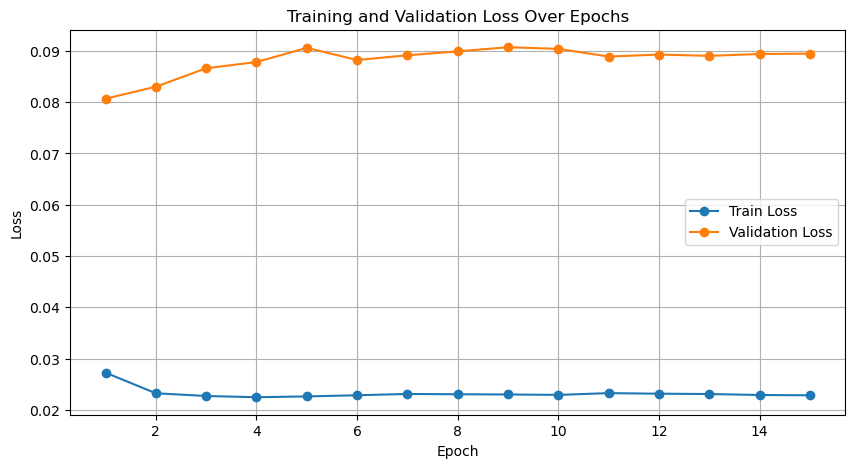

In [139]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# 假设 model、criterion、train_loader、test_loader 和 device 已经定义
train_losses = []
val_losses = []

# 设置总训练轮数为 15
num_epochs = 15

# 定义初始学习率
initial_lr = 0.001

# 定义优化器（Adam）
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# 定义学习率调度器，每 5 个 epoch 将学习率减半
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 检查损失异常
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Loss is NaN or Inf at Epoch {epoch+1}, Batch {batch_idx+1}")
            break
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
        optimizer.step()
        
        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # 计算并记录训练损失
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

    # 验证阶段
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
        # 计算并记录验证损失
        epoch_loss = running_loss / len(test_loader)
        val_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}")

    # 更新学习率（每 5 个 epoch 减半）
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Current Learning Rate: {scheduler.get_last_lr()[0]}")

# 绘制损失变化图
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

In [140]:
torch.save(model.state_dict(), 'model.pth')